# ACS2 in HandEye environment with Action Planning

This notebook presents how to use HandEye environment and how it works with and without _Action Planning_, which makes gaining the knowledge about the environment about two times faster than without that mechanism. 

**References**:
* _"Action-Planning in Anticipatory Classifier Systems"_ by Martin Butz and Wolfgang Stolzmann

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

import gym
import gym_handeye

# Import PyALCS code from local path
import sys, os
sys.path.append(os.path.abspath('../../..'))

from lcs.agents.acs2 import ACS2, Configuration
from lcs.metrics import population_metrics

from examples.acs2.handeye.utils import handeye_metrics

## Environment

Initialize an OpenAI Gym compliant environment. HandEye is not in included standard repo - you can fetch it from [here](https://github.com/ParrotPrediction/openai-envs).

In [2]:
hand_eye = gym.make('HandEye3-v0')

state = hand_eye.reset()

hand_eye.render()


□□□
#□□
□■□


In the rendered state above, color white is for surface, green is for gripper, and blue is for block.

> The number after the name of the environment (in this example - '3') stands for the size of the environment.
> You can use environments of size from 2 up to 9, ex. `HandEye5-v0` is an environment of size 5.

We can perform actions on the environment.

There are 6 actions:
- `0` - move north
- `1` - move east
- `2` - move south,
- `3` - move west
- `4` - grip the block
- `5` - release the block

In [3]:
action = 0  # move North

state, reward, done, _ = hand_eye.step(action)

hand_eye.render()


#□□
□□□
□■□


We can also display state of the environment as a tuple, line by line. `w` stands for the surface, `b` is for block and `g` is for gripper. The last element is the feeling sensor of the gripper. `0` means no feel of block, `1` means the block is under the gripper, and `2` means the block is in hand.

In [4]:
state

('g', 'w', 'w', 'w', 'w', 'w', 'w', 'b', 'w', '0')

In this environment, the reward is always 0, because there is no goal. Therefore, it is harder to learn the good moves.

In [5]:
reward

0

## The agent

After creating the environment, we need to configure the agent.

In [6]:
# custom function for metrics collection
def _metrics_collector(pop, env):
    # environment specific metrics
    metrics = handeye_metrics(pop, env)
    
    # add basic population metrics (like numerosity etc.)
    metrics.update(population_metrics(pop, env))
    
    return metrics

cfg = Configuration(hand_eye.observation_space.n, hand_eye.action_space.n,
                    epsilon=1.0,
                    do_ga=False,
                    do_action_planning=True,
                    action_planning_frequency=50,
                    user_metrics_collector_fcn=_metrics_collector)

As you can see, we set the `do_action_planning` parameter to `True`. You can of course use this environment without Action Planning by simply setting it to `False`.

`action_planning_frequency` parameter sets the frequency of the Action Planning phase, meaning that every 50 steps the agent will enter the Action Planning phase.

Now we can just create the ACS2 agent to explore the environment. I set the number of trials in the explore phase to 5 and in the exploit phase to 1. Each trial has up to 500 steps (usually exactly 500).

In [7]:
%%time

# Explore the environment
agent = ACS2(cfg)
population, explore_metrics = agent.explore(hand_eye, 5)

CPU times: user 6.19 s, sys: 111 ms, total: 6.3 s
Wall time: 6.88 s


In [8]:
%%time

# Exploit the environment
agent = ACS2(cfg, population)
population, exploit_metrics = agent.exploit(hand_eye, 1)

CPU times: user 1.48 s, sys: 26.1 ms, total: 1.51 s
Wall time: 1.61 s


Creating the environment and running an agent in it is really simple.

## Action Planning

Every 50 steps the Action Planning phase takes place. 

Firstly, it starts with getting the goal state from the environment's goal-generator - the function `get_goal_state`. Not every environment has it. Action Planning won't work in an environment without the function `get_goal_state`.

If it has the goal, it starts searching for the sequence of moves to change current state into the goal state. It is done by a bidirectional search algorithm using only reliable classifiers. It there are no reliable classifiers to anticipate the change from the current state to the goal state, the goal sequence is not found and the agent goes back to the exploration phase. Notice that when the agent doesn't have full knowledge about the environment, it may find a sequence that is longer than the shortest sequence.

Once the goal sequence is found, the agent executes each action and learns during executing. Then it asks the environment for the next goal. It is done as long as there are new goals and it can find a sequence of moves from a current state to a goal state.

> ### HandEye environment
> The Action Planning phase is really helpful in the environments like HandEye - without one specific goal to reach. 
> The goal generator of the HandEye environment generates continuously the following states:
    1. Move over the block
    2. Grip the block
    3. Move with the block to a random position
    4. Release the block
    5. Move to a random position not over the block
> In the normal exploration phase, the environment is rarely in the position with block in hand. In Action Planning phase, however, it has to continously find the block, move over it, grip it and move it elsewhere. There are a lot less actions with block than without block. Even in 2x2 environment, actions with block take only 32% of all possible actions and for bigger environments this percentage is even smaller (ex. 3x3 - 16%, 7x7 - 3.1%).

## Results

If we want to compare the result from the HandEye environment with and without Action Planning, the most convenient way is to use figures. Of course the ACS2 agent is non-deterministic, but we won't worry about it now.

To see how Action Planning helps the agent gain knowledge about the environment, we can compare three metrics: overall knowledge, knowledge about the transitions with block (grip the block, release the block or move the block), and knowledge about the transitions without block (moving the gripper without the block).

In [9]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        row['with_block'] = row['with_block']
        row['no_block'] = row['no_block']
        return row

    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)

    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'

    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)

    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial'] + len(explore_df), axis=1)

    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.drop(['reward'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)

    return df

In [10]:
# print the format of collected metrics (example)
df = parse_metrics_to_df(explore_metrics, exploit_metrics)
df

,knowledge,no_block,numerosity,population,reliable,steps_in_trial,with_block,phase,steps
trial,,,,,,,,,
0,0.000000,0.0,204,204,3,500,0.000000,explore,500
1,52.713178,62.5,588,588,60,500,2.380952,exploit,500


Then, we need some functions to help in plotting the results we get from the environment.

In [11]:
# plotting constants
TITLE_TEXT_SIZE = 24
AXIS_TEXT_SIZE = 18
LEGEND_TEXT_SIZE = 16

In [12]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['knowledge'].plot(ax=ax, c='blue')
    explore_df['with_block'].plot(ax=ax, c='green')
    explore_df['no_block'].plot(ax=ax, c='yellow')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title(f'Achieved knowledge', fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])
    ax.legend(fontsize=LEGEND_TEXT_SIZE)

In [13]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')

    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)

In [14]:
def plot_performance(metrics_df, env_name, additional_info=""):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'Performance in {env_name} environment {additional_info}', fontsize=32)

    ax2 = plt.subplot(211)
    plot_knowledge(metrics_df, ax2)

    ax3 = plt.subplot(212)
    plot_classifiers(metrics_df, ax3)

    plt.subplots_adjust(top=0.82, wspace=0.3, hspace=0.4)

Then, finally, we can use the above functions and plot the results with and without Action Planning.

In [15]:
def perform_experiment(env, do_action_planning=True, trials_explore=50, trials_exploit=10):
    # build agent configuration
    cfg = Configuration(hand_eye.observation_space.n, hand_eye.action_space.n,
                        epsilon=1.0,
                        do_ga=False,
                        do_action_planning=do_action_planning,
                        metrics_trial_frequency=1,
                        user_metrics_collector_fcn=_metrics_collector)

    # explore phase
    agent_he = ACS2(cfg)
    population_he_explore, metrics_he_explore = agent_he.explore(hand_eye, trials_explore)

    # exploit phase
    agent_he = ACS2(cfg, population_he_explore)
    _, metrics_he_exploit = agent_he.exploit(hand_eye, trials_exploit)
    
    # metrics preprocessing
    he_metrics_df = parse_metrics_to_df(metrics_he_explore, metrics_he_exploit)
    
    return he_metrics_df

It may take a while, so be patient. Usually, `HandEye3-v0` environment takes about 2 minutes to complete. Bigger environments need more time.

> Note: in `perform_experiment` in each trial the agent executes fixed number of steps (500). If you want to test bigger environments, you may need bigger number of trials to achieve 100% knowledge.

In [16]:
env = gym.make('HandEye3-v0')

CPU times: user 1min 16s, sys: 263 ms, total: 1min 16s
Wall time: 1min 17s


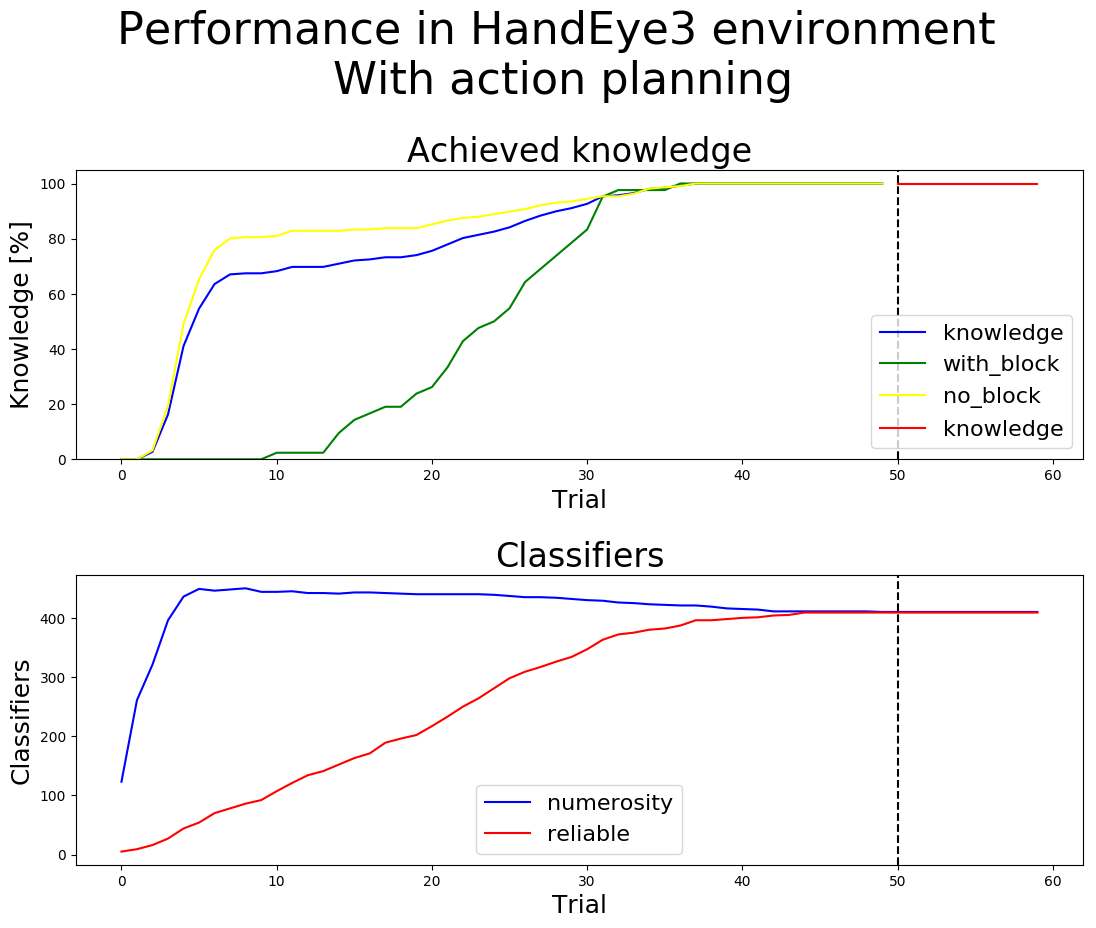

In [17]:
%%time
m_df = perform_experiment(env, do_action_planning=True)
plot_performance(m_df, env.spec._env_name, f'\nwith action planning')

CPU times: user 1min 15s, sys: 773 ms, total: 1min 16s
Wall time: 1min 19s


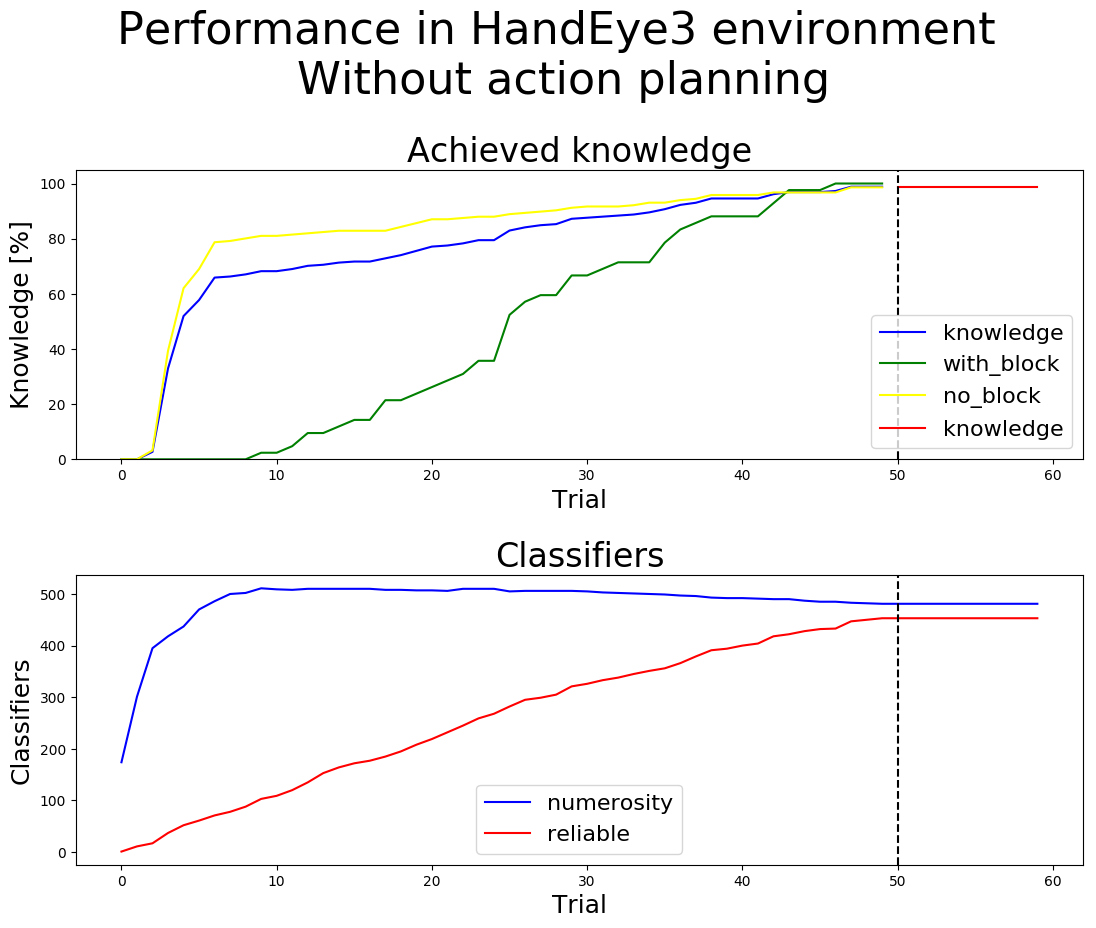

In [18]:
%%time
m_df = perform_experiment(env, do_action_planning=False)
plot_performance(m_df, env.spec._env_name, f'\nwithout action planning')

Remember that each trial means 500 steps. In most of the results (not all because of non-deterministic nature of ACS2), we can see that when using Action Planning, we achieve full knowledge (100.0%) about 6-8 trials faster (sometimes more, sometimes less than that). It may seem like a really small difference, but it is actually about 3000-4000 steps.

What is even more important, we achieve knowledge about transitions with block faster than without Action Planning. This is essential, because moves with block are more useful for the real use of the environment.

Of course, this is only one sample of a non-deterministic agent. The results shown above are not 'rules'. They are not in any way relevant and do not show even typical behaviour of PyALCS with Action Planning. That's why it's important to see how it works with avarage results of more than just one experiment.